---
title: "fast.ai Chapter 6: Classification Models"
date: '2021-04-12'
author: "Vishal Bakshi"
categories:
    - deep learning
    - python
freeze: true
---

![An example image from the image dataset used in this lesson. The image has a train going over a bridge with skyscrapers in the background.](boat-train.png)

This chapter introduced two more classification models:

- Multi-label classification, for when you want to predict more than one or no label per image
- Regression, for when you want to predict a quantity instead of a category for an image

In this chapter the authors walk us through in the chapter is the PASCAL dataset.

---

Here's my video walkthrough for this notebook:

In [1]:
#| include: false
from IPython.display import HTML

In [6]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/cJOtrHtzDSU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Setup

In [ ]:
#| include: false
!pip install -Uqq fastai 
!pip install -Uqq fastcore

     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
#| include: false
import fastai
fastai.__version__

'2.3.0'

In [ ]:
#| include: false
from fastai.vision.all import *

## The Data

fastai comes with datasets available for download using the `URLs` object. We will use the `PASCAL_2007` dataset.

In [ ]:
# download the dataset
path = untar_data(URLs.PASCAL_2007)

#read label CSV into a DataFrame
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Next, they have us go through some pandas fundamentals for accessing data in a DataFrame

In [ ]:
# accessing all rows and the 0th column
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
# accessing all columns for the 0th row
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [ ]:
# trailing :s are not needed
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [ ]:
# accessing a column by its name
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
# creating a new DataFrame and performing operations on it
df1 = pd.DataFrame()

# adding a new column
df1['a'] = [1,2,3,4]
df1

,a
0,1
1,2
2,3
3,4


In [ ]:
# adding a new column
df1['b'] = [10, 20, 30, 40]

# adding two columns
df1['a'] + df1['b']

0    11
1    22
2    33
3    44
dtype: int64

## Constructing a DataBlock

A DataBlock can be used to create Datasets from which DataLoaders can be created to use during training. A DataBlock is an object which contains the data and has helper functions which can access and transform the data.

They start by creating an empty DataBlock

In [ ]:
dblock = DataBlock()
dblock

The DataFrame with filenames and labels can be fed to the DataBlock to create a Datasets object, which is
> an iterator that contains a training Dataset and validation Dataset

Each dataset is

> a collection that returns a tuple of your independent and dependent variable for a single item

A Dataet created from an empty DataBlock (meaning, a DataBlock with no helper functions to tell it how the data is structured and accessed) will contain a tuple for each row of the DataFrame, where both values of the tuple are the same row.

In [ ]:
dsets = dblock.datasets(df)
dsets.train[0]

(fname                   005618.jpg
 labels      tvmonitor chair person
 is_valid                      True
 Name: 2820, dtype: object, fname                   005618.jpg
 labels      tvmonitor chair person
 is_valid                      True
 Name: 2820, dtype: object)

What we want is for the DataBlock to create Datasets of (independent, dependent) values. In this case, the independent variable is the image and the dependent variable is a list of labels. 

In order to parse the DataFrame rows, we need to provide two helper functions to the DataBlock: `get_x` and `get_y`. In ordert to convert them to the appropriate objects that will be used in training, we need to provide two more arguments: `ImageBlock` and `MultiCategoryBlock`. In order for the DataBlock to correctly split the data into training and validation datasets, we need to define a `splitter` function and pass it as an argument as well.

`get_x` will access the filename from each row of the DataFrame and convert it to a file path.

`get_y` will access the labels from each row and split them into a list.

`ImageBlock` will take the file path and convert it to a `PILImage` object.

`MultiCategoryBlock` will convert the list of labels to a one-hot encoded tensor using the Dataset's `vocab`. 

`splitter` will explicitly choose for the validation set the rows where `is_valid` is `True`.

`RandomResizedCrop` will ensure that each image is the same size, which is a requirement for creating a tensor with all images.

In [ ]:
def get_x(row): return path/'train'/row['fname']
def get_y(row): return row['labels'].split(' ')
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dls = dblock.dataloaders(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

The Datasets `vocab` is a list of alphabetically ordered unique labels:

In [ ]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

Let me breakdown the tuple returned by `dsets.train[0]`. The first value is a `PILImage`object which can be viewed by calling its `show()` method:

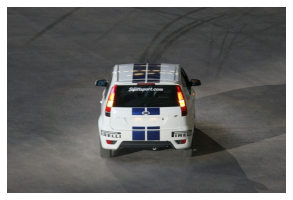

In [ ]:
dsets.train[0][0].show()

The second value is a one-hot encoded list, where `1`s are in the location of the labels in the corresponding vocab list. I'll use the `torch.where` method to access the indices where there are `1`s:

In [ ]:
torch.where(dsets.train[0][1]==1)

(TensorMultiCategory([6]),)

In [ ]:
dsets.train.vocab[torch.where(dsets.train[0][1]==1)[0]]

(#1) ['car']

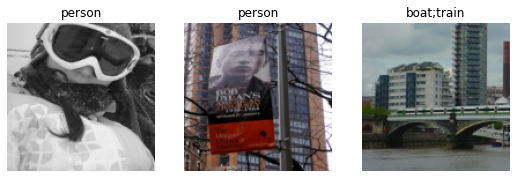

In [ ]:
dls.show_batch(nrows=1, ncols=3)

## Chapter 4: Two-Digit MNIST Classifier

I'll first review the loss function used in the single-label classification models created in Chapters 4 and 5 before reviewing Binary Cross Entropy Loss introduced in this chapter.



In this chapter, we built a image classifier which would predict if an input image was an of the digit 3 or the digit 7.


The target (or expected outcome) is a list of 0s (for 7) and 1s (for 3). If we gave a batch of images of a 3, a 7 and a 3, the target would be `[1, 0, 1]`.

Suppose the model predicted the following values: `[0.9, 0.4, 0.2]` where each value represented the probability or confidence it had that each image was a 3. 

Loss represents the positive difference between the target and the prediction: 
- 1 - prediction when target == 1
- prediction when target == 0

For the first image, the model had 90% confidence it was a 3, and it was indeed a 3. The loss is `1 - 0.9` = `0.1`.

For the second second image, the model had a 40% confidence it was a three, and the image was of a 7. The loss is `0.4`.

For the last image, the model had a 20% confidence it was a 3, and the image was a 3. The loss is `1 - 0.2` = `0.8`.

The average of these three losses is `1.3/3` or `0.433`. 

The following cell illustrates this with code:

In [ ]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

targets = tensor([1,0,1])
predictions = tensor([0.9, 0.4, 0.2])
mnist_loss(predictions=predictions, targets=targets)

tensor(0.4333)

The assumption that this loss function makes is that the predictions are always between 0 and 1. That may not always be true! In order to make this assumption explicit, we take the sigmoid of the prediction before calculating the loss. The sigmoid function outputs a value between 0 and 1 for any input value.

In [ ]:
tensor([0.4,-100,200]).sigmoid()

tensor([0.5987, 0.0000, 1.0000])

In [ ]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

## Chapter 5: 37 Breed Pet Classifier

In this chapter, we train an image classifier that when given an input image, predicts which of the 37  pet breeds the image shows. The loss function needs to handle 37 activations for each image. In order to ensure the sum of those activations equals 1.0---so that the highest activation represents the model's highest confidence---the softmax function is used. In order to increase the separation between probabilities, the softmax function's output is passed through the logarithm function, and the negative value is taken. The combination of softmax and (negative) logarithm is called _cross entropy loss_.

Suppose we had 4 images in a batch. The model would output activations something like this:

In [ ]:
# create a pseudo-random 4 x 37 tensor 
# with values from -2 to 2
acts = (-2 - 2) * torch.rand(4, 37) + 2
acts

tensor([[-1.9994e+00,  7.0629e-01, -1.8230e+00,  8.6118e-02,  8.8579e-01,
         -9.7763e-01,  9.7619e-01,  5.4613e-01,  9.2020e-01,  8.2653e-01,
         -1.3831e+00,  1.2236e+00, -4.2582e-01,  1.1371e+00,  1.2409e+00,
          1.4403e-02, -9.2988e-01, -1.1939e+00, -9.9743e-01, -1.9572e+00,
         -6.8404e-02,  6.2455e-01,  8.6748e-01, -1.4574e+00, -1.4451e+00,
          1.1349e-01,  1.7424e+00,  6.5414e-02, -1.2517e+00, -1.9933e+00,
         -1.5570e+00,  1.3880e+00,  1.5099e+00,  6.2576e-01, -1.4279e-03,
          1.7448e+00,  1.9862e+00],
        [ 4.5219e-02,  4.6843e-01, -1.1474e+00, -1.8876e+00, -5.7879e-01,
          6.9787e-01, -7.2457e-02, -1.7235e+00, -9.9028e-01,  1.2248e+00,
          6.4889e-01,  5.0363e-01,  1.8472e-01, -1.0468e+00, -1.0113e+00,
         -1.0628e+00,  1.9783e+00, -1.8394e+00, -8.0410e-02, -5.9383e-01,
         -1.6868e+00, -2.6366e-01, -8.3354e-01,  6.8552e-01, -8.6600e-02,
          1.6034e+00,  7.3355e-01,  1.3205e+00,  1.4004e+00, -5.2889e-01,
  

Passing these through softmax will normalize them from 0 to 1:

In [ ]:
sm_acts = acts.softmax(dim=1)
sm_acts[0], sm_acts[0].sum()

(tensor([0.0020, 0.0302, 0.0024, 0.0162, 0.0361, 0.0056, 0.0396, 0.0257, 0.0374,
         0.0341, 0.0037, 0.0507, 0.0097, 0.0465, 0.0516, 0.0151, 0.0059, 0.0045,
         0.0055, 0.0021, 0.0139, 0.0278, 0.0355, 0.0035, 0.0035, 0.0167, 0.0851,
         0.0159, 0.0043, 0.0020, 0.0031, 0.0597, 0.0675, 0.0279, 0.0149, 0.0853,
         0.1086]), tensor(1.0000))

Taking the negative log of this tensor will give us the final loss:

In [ ]:
nll_loss = -1. * torch.log(sm_acts)
nll_loss

tensor([[6.2054, 3.4997, 6.0290, 4.1199, 3.3202, 5.1836, 3.2298, 3.6599, 3.2858,
         3.3795, 5.5891, 2.9825, 4.6318, 3.0690, 2.9651, 4.1916, 5.1359, 5.3999,
         5.2035, 6.1632, 4.2744, 3.5815, 3.3385, 5.6635, 5.6511, 4.0925, 2.4636,
         4.1406, 5.4577, 6.1994, 5.7630, 2.8180, 2.6961, 3.5803, 4.2074, 2.4612,
         2.2198],
        [3.9156, 3.4924, 5.1082, 5.8484, 4.5396, 3.2629, 4.0333, 5.6843, 4.9511,
         2.7360, 3.3119, 3.4572, 3.7761, 5.0076, 4.9721, 5.0235, 1.9825, 5.8002,
         4.0412, 4.5546, 5.6476, 4.2245, 4.7943, 3.2753, 4.0474, 2.3574, 3.2273,
         2.6403, 2.5604, 4.4897, 3.3934, 4.9304, 5.4605, 3.4919, 5.6936, 2.9306,
         4.5375],
        [4.3197, 3.1604, 4.7881, 5.6121, 5.8895, 5.6548, 3.5817, 3.8985, 4.6048,
         5.1662, 5.4429, 4.3902, 3.4167, 3.4435, 2.7574, 4.6681, 4.9462, 4.4278,
         4.1470, 4.7753, 6.0016, 5.6790, 2.7793, 5.0546, 3.1774, 2.4718, 5.9102,
         5.4131, 5.5785, 2.1562, 2.2205, 4.4743, 4.6305, 2.8130, 3.1577, 

Suppose the target for each image was given by the following tensor, where the target is an integer from 0 to 36 representing one of the pet breeds:

In [ ]:
targs = tensor([3, 0, 34, 10])
idx = range(4)
nll_loss[idx, targs]

tensor([4.1199, 3.9156, 3.1577, 4.6348])

In [ ]:
def cross_entropy(acts, targs):
  idx = range(len(targs))
  sm_acts = acts.softmax(dim=1)
  nll_loss = -1. * torch.log(sm_acts)
  return nll_loss[idx, targs].mean()

I compare this with the built-in `F.cross_entropy` and `nn.CrossEntropyLoss` functions:

In [ ]:
F.cross_entropy(acts, targs,reduction='none')

tensor([4.1199, 3.9156, 3.1577, 4.6348])

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targs)

tensor([4.1199, 3.9156, 3.1577, 4.6348])

Note that the `nn` version of the loss function returns an instantiation of that function which then must be called with the activations and targets as its inputs.

In [ ]:
type(nn.CrossEntropyLoss(reduction='none'))

torch.nn.modules.loss.CrossEntropyLoss

## Binary Cross Entropy Loss

The authors begin the discussion of explaining the multi-label classification model loss function by observing the activations from the trained model. I'll do the same---I love that approach since it grounds the concepts involved in the construction of loss function in the actual model outputs.

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
x, y = dls.train.one_batch()
if torch.cuda.is_available():
    learn.model.cuda()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Each batch has 64 images and each of those images has 20 activations, one for each label in `.vocab`. Currently, they are not restricted to values between 0 and 1.

_Note: the activations tensor has to first be placed on the cpu and then detached from the graph (which is used to track and calculate gradients of the weights with respect to the loss function) before it can be converted to a numpy array used for the plot._

<BarContainer object of 20 artists>

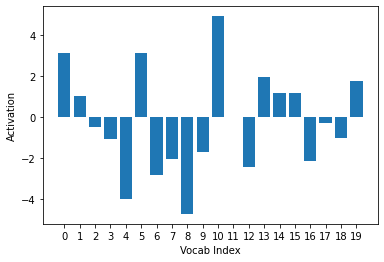

In [ ]:
ys = activs[0].cpu().detach().numpy()

plt.xlabel("Vocab Index")
plt.ylabel("Activation")
plt.xticks(np.arange(20), np.arange(20))
plt.bar(range(20), ys)

Passing them through a sigmoid function achieves that:

<BarContainer object of 20 artists>

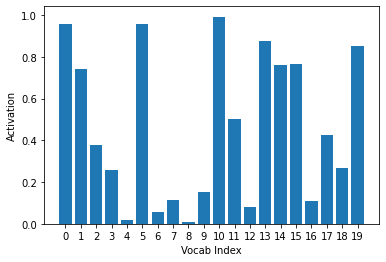

In [ ]:
ys = activs[0].sigmoid().cpu().detach().numpy()

plt.xlabel("Vocab Index")
plt.ylabel("Activation")
plt.xticks(np.arange(20), np.arange(20))
plt.bar(range(20), ys)

The negative log of the activations is taken in order to push the differences between loss values. For vocab where the target is `1`, `-log(inputs)` is calculated. For vocab where the target is `0`, `-log(1-inputs)` is calculated. This seems counterintuitive at first, but let's take a look at the plot of these functions:

<BarContainer object of 20 artists>

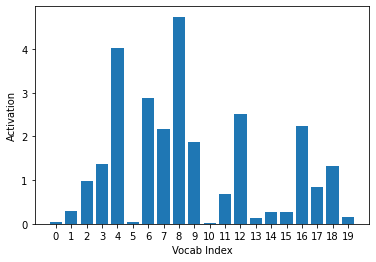

In [ ]:
ys = -activs[0].sigmoid().log().cpu().detach().numpy()

plt.xlabel("Vocab Index")
plt.ylabel("Activation")
plt.xticks(np.arange(20), np.arange(20))
plt.bar(range(20), ys)

The sigmoid activations that were very close to `0` (Vocab Index = `0`, `2`, `5`, and `16`) are now much larger than those that were very close to `1` (Vocab Index = `6`, `14`, and `18`). Since the target is `1`, this correctly assigns a larger loss to the inaccurate predictions and the smaller loss to the accurate ones. We can say the same (but opposite) for `-log(1-inputs)`, which is used when the target is `0`.:

<BarContainer object of 20 artists>

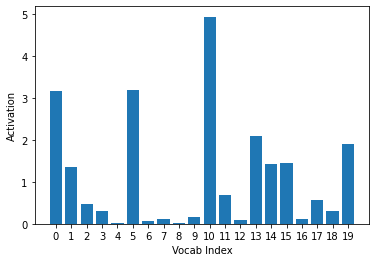

In [ ]:
ys = -(1- activs[0].sigmoid()).log().cpu().detach().numpy()

plt.xlabel("Vocab Index")
plt.ylabel("Activation")
plt.xticks(np.arange(20), np.arange(20))
plt.bar(range(20), ys)

Finally, the `mean` of all image loss values is taken for the batch. The Binary Cross Entropy Function look likes this:

In [ ]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

The `inputs`  (the activations for each `vocab` value)) is the first value and the `targets` of each image are the second value of the `dls.train.one_batch()` tuple.

In [ ]:
binary_cross_entropy(activs,y)

TensorMultiCategory(1.0472, device='cuda:0', grad_fn=<AliasBackward>)

I will compare this with the built-in function `F.binary_cross_entropy_with_logits` and function class `nn.BCEWithLogitsLoss` to make sure I receive the same result.

In [ ]:
F.binary_cross_entropy_with_logits(activs,y)

TensorMultiCategory(1.0472, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
nn.BCEWithLogitsLoss()(activs,y)

TensorMultiCategory(1.0472, device='cuda:0', grad_fn=<AliasBackward>)

## Mult-Label Classification Accuracy

For single-label classification, the accuracy function compared whether the index of the highest activation matched the index of the target `vocab`. A single index for a single label. 

In [ ]:
def accuracy(inputs, targets, axis=-1):
  predictions = inputs.argmax(dim=axis)
  return (predictions==targets).float().mean()

For multi-label classification, each image can have more than one correct corresponding `vocab` index and the corresponding activations may not be the maximum of the `inputs` tensor. So instead of using the maximum, a threshold is used to identify predictions. If the activation is above that threshold, it's considered to be a prediction.

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp > thresh)==targ.bool()).float().mean()

`targ` is a one-hot encoded Tensor, so `1`s are converted to `True` and `0`s are converted to `False` using the `.bool` method.

## Training the Model

At last! I can now train the model, setting a different accuracy threshold as needed using the built-in `partial` function.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.942256,0.698276,0.239323,00:29
1,0.821279,0.566598,0.281633,00:28
2,0.602543,0.208145,0.805498,00:28
3,0.359614,0.125162,0.939801,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133149,0.112483,0.947072,00:29
1,0.115643,0.105032,0.953028,00:29
2,0.096643,0.103564,0.952769,00:29


In about three and a half minutes, this model was able to achieve more than 95% accuracy. I'll look at its predictions on the validation images:

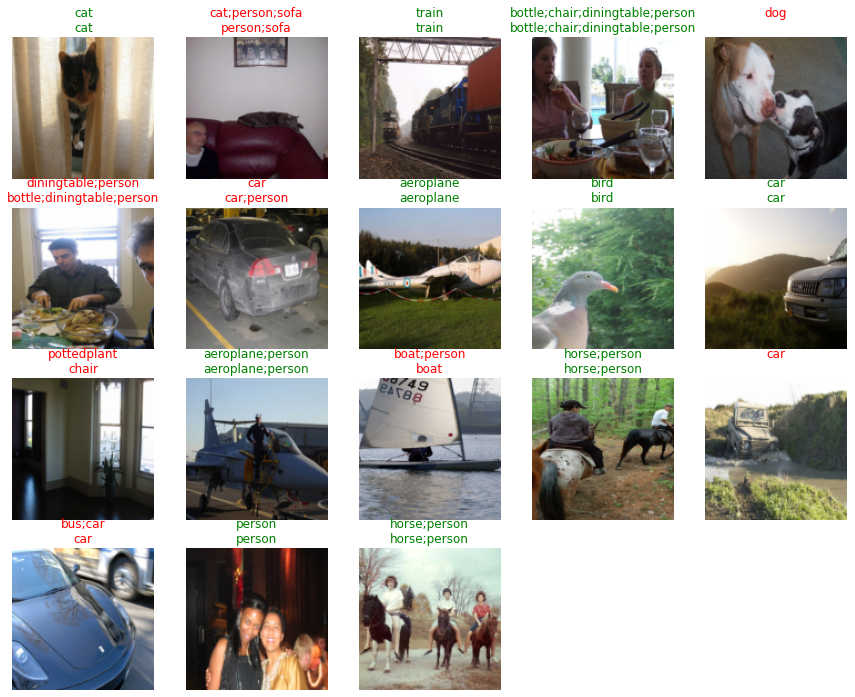

In [ ]:
learn.show_results(max_n=18)

Varying the threshold will vary the accuracy of the model. The `metrics` of the learner can be changed after training, and calling the `validate` method will recalculate the accuracy:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.1035640612244606,0.930816650390625]

A threshold of `0.1` decreases the accuracy of the model, as does a threshold of `0.99`. A `0.1` threshold includes labels for which the model was not confident, and a `0.99` threshold exclused labels for which the model was not _very_ confident. I can calculate and plot the accuracy for a range of thresholds, as they did in the book:

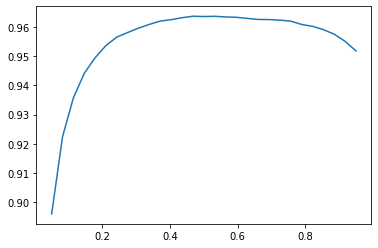

In [ ]:
preds, targs = learn.get_preds()
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [ ]:
best_threshold = xs[np.argmax(accs)]
best_threshold

tensor(0.4679)

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=best_threshold)
learn.validate()

(#2) [0.1035640612244606,0.9636053442955017]

The highest accuracy (96.36%) is achieved when the threshold is 0.4679.

## Regression

The authors provide some context here which, while I can appreciate, judge I won't fully understand until I experience the next 5 or 6 chapters.

> A model is defined by its independent and dependent variables, along with its loss function. The means that there's really a far wider array of models than just the simple domain-based split

The "domain-based split" is a reference to the distinction between computer vision, NLP and other different types of problems. 

To illustrate their point, they have us work through an image regression problem with much of the same process (and model) as an image classification problem.

In [ ]:
# download data
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
# helper functions to retrieve images
# and to retrieve text files
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

In [ ]:
# check that `img2pose` converts file name correctly
img_files[0], img2pose(img_files[0])

(Path('/root/.fastai/data/biwi_head_pose/03/frame_00457_rgb.jpg'),
 Path('/root/.fastai/data/biwi_head_pose/03/frame_00457_pose.txt'))

In [ ]:
# check image size
im = PILImage.create(img_files[0])
im.shape

(480, 640)

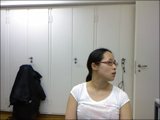

In [ ]:
# view the image
im.to_thumb(160)

In [ ]:
# helper function to extract coordinates
# of the subject's center of head
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [ ]:
# check coordinates of the first file
get_ctr(img_files[0])

tensor([444.7946, 261.7657])

In [ ]:
# create the DataBlock
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

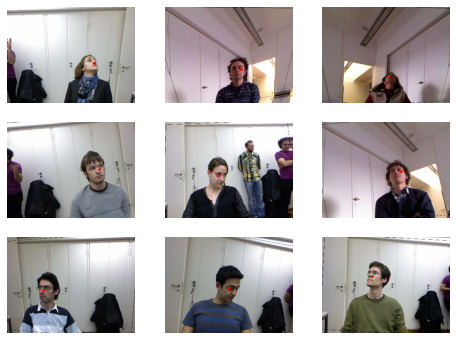

In [ ]:
# confirm that the data looks OK
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
# view tensors
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Each batch has 64 images. Each image has 3 channels (rgb) and is 240x320 pixels in size. Each image has 1 pair of coordinates.

In [ ]:
# view a single coordinate pair
yb[0]

TensorPoint([[0.0170, 0.3403]], device='cuda:0')

In [ ]:
# create Learner object
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The `y_range` argument shifts the final layer's sigmoid output to a coordinate between -1 and 1. The sigmoid function is transformed using the following function.

In [ ]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

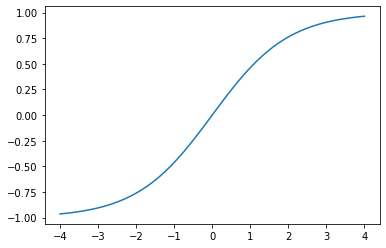

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [ ]:
# confirm loss function
dls.loss_func

FlattenedLoss of MSELoss()

fastai has chosen MSE as the loss function, which is appropriate for a regression problem.

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.033113110810518265)

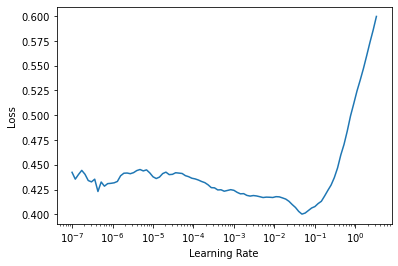

In [ ]:
# pick a learning rate
learn.lr_find()

In [ ]:
# use lr = 2e-2
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.047852,0.011552,01:55
1,0.007220,0.002150,01:56
2,0.003190,0.001313,01:56
3,0.002376,0.000295,01:56
4,0.001650,0.000106,01:54


A loss of 0.000106 is an accuracy of:

In [ ]:
math.sqrt(0.000106)

0.010295630140987

The conclusion to this (what has felt like a marathon of a) chapter is profound:

> In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different number of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem...make sure you think hard about your loss function, and remember that you most probably want the following:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression